In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from cir_utils import *

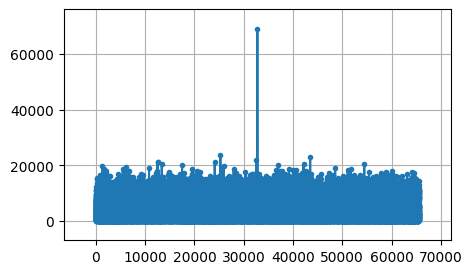

Ideal Peak: 69129.3373438533
Ideal SNR: 16.91460781280311


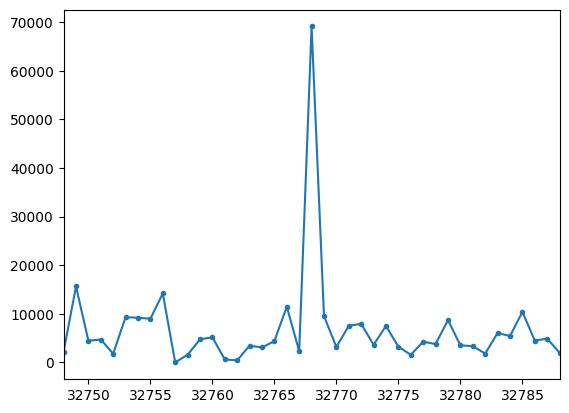

In [16]:
corr_code = read_packed_kasami_h('./kasami_code/kasami_packed_16bit_120.h')
corr_code = 2 * corr_code - 1  # Convert to bipolar (-1, 1) format
seq_len = len(corr_code)

shifted_corr_code = corr_code + np.random.normal(0, 20, size=seq_len)

# corr_code_repeated = np.repeat(corr_code, 2)
# assert (corr_code_repeated[1::2] == corr_code).all(), "Error in repeating the code!"

# random_indices = np.random.choice(len(corr_code_repeated), 2, replace=False)
# print(f"Randomly picked indices: {random_indices}")
# sampled = np.delete(corr_code_repeated, random_indices)
# # assert len(sampled) == len(corr_code), "Error in deleting one sample!"

ideal_corr = autocorr_same_length(shifted_corr_code, np.roll(corr_code, seq_len//2), showFig=True)
print(f"Ideal Peak: {np.max(ideal_corr)}")
print(f"Ideal SNR: {np.max(ideal_corr) / np.mean(ideal_corr[1:])}")
plt.plot(ideal_corr, '.-')
plt.xlim(np.argmax(ideal_corr)-20, np.argmax(ideal_corr)+20)
plt.show()

In [75]:
def generate_resampled_template_with_phase(
    pn_sequence: np.ndarray,
    drift_ppm: float,
    samples_per_symbol: int,
    num_output_samples: int,
    initial_phase: float = 0.0,
    integration_duration: int = 0,
) -> np.ndarray:
    """
    Generates a resampled PN sequence template to account for clock drift and initial phase.

    Args:
        pn_sequence: The original, ideal bipolar (+1/-1) PN sequence.
        drift_ppm: The hypothetical clock drift in Parts Per Million (PPM).
        samples_per_symbol: The number of samples per symbol at zero drift.
        num_output_samples: The total number of samples for the output template.
        initial_phase: The initial phase offset as a fraction of one symbol period (0.0 to 1.0).
                       This accounts for sub-symbol alignment.
        integration_duration: The duration over which to integrate samples (default is 0, meaning no integration).

    Returns:
        A resampled bipolar (+1/-1) numpy array of length num_output_samples.
    """
    drift_factor = 1.0 + (drift_ppm / 1_000_000.0)
    
    # Convert the fractional phase into an offset in units of samples.
    phase_offset_samples = initial_phase * samples_per_symbol
    
    # Create an array of receiver sample indices: [0, 1, 2, ...]
    n = np.arange(num_output_samples) # start_sampled_time

    # apply drift and initial phase
    shifted_drifted_start_time = (n + phase_offset_samples) / (samples_per_symbol * drift_factor)
    shifted_drifted_end_time = shifted_drifted_start_time + (integration_duration / drift_factor)

    # for those int(floor(start_time)) == int(floor(end_time)), we can directly assign the value
    # otherwise, we need to do a linear interpolation between the two symbols
    resampled_sequence = np.zeros(num_output_samples)
    same_indices = (np.floor(shifted_drifted_start_time) == np.floor(shifted_drifted_end_time))
    resampled_sequence[same_indices] = pn_sequence[np.floor(shifted_drifted_start_time[same_indices]).astype(int) % len(pn_sequence)]
    
    # For the rest, we do linear interpolation
    diff_indices = ~same_indices
    start_indices = np.floor(shifted_drifted_start_time[diff_indices]).astype(int) % len(pn_sequence)
    end_indices = np.floor(shifted_drifted_end_time[diff_indices]).astype(int) % len(pn_sequence)
    start_weights = 1 - (shifted_drifted_start_time[diff_indices] - np.floor(shifted_drifted_start_time[diff_indices]))
    end_weights = shifted_drifted_end_time[diff_indices] - np.floor(shifted_drifted_end_time[diff_indices])
    resampled_sequence[diff_indices] = (pn_sequence[start_indices] * start_weights + pn_sequence[end_indices] * end_weights) / (start_weights + end_weights)
    return resampled_sequence

# 1. System Parameters
PN_SYMBOL_RATE = 512  # Hz
SAMPLING_RATE = 1024  # Hz
SAMPLES_PER_SYMBOL = SAMPLING_RATE // PN_SYMBOL_RATE # Should be 2
INTERATION_DURATION = 0.52 / 1000 * PN_SYMBOL_RATE  # 0.52ms integration duration in samples

# 2. Get the ideal PN sequence
base_pn_sequence = corr_code

# 3. Define the length of our desired output
# Let's generate enough samples to see a few repetitions of the pattern.
num_samples_to_generate = 2*(2**16 - 1)

print(f"Base PN Sequence: {base_pn_sequence[0:32]}")
print(f"Samples per Symbol: {SAMPLES_PER_SYMBOL}\n")

# --- DEMONSTRATION ---

# Case 1: No drift (should be a perfect sequence)
template_no_drift = generate_resampled_template_with_phase(
    base_pn_sequence,
    drift_ppm=0,
    samples_per_symbol=SAMPLES_PER_SYMBOL,
    num_output_samples=num_samples_to_generate,
    initial_phase=0.0,
    integration_duration=INTERATION_DURATION
)
print(f"Drift = 0 PPM:\n{template_no_drift[0:32]}\n, length: {len(template_no_drift)}\n")

# Case 2: Positive drift (tag clock is SLOWER, symbols are LONGER)
# Let's use a large drift to make the effect obvious.
# A symbol that should be 2 samples long will now be 2 * (1 + 0.1) = 2.2 samples.
# We should see some symbols being held for 3 samples instead of 2.
template_positive_drift = generate_resampled_template_with_phase(
    base_pn_sequence,
    drift_ppm=20, # +20 PPM drift
    samples_per_symbol=SAMPLES_PER_SYMBOL,
    num_output_samples=num_samples_to_generate,
    initial_phase=0.0,
    integration_duration=INTERATION_DURATION
)
print(f"Drift = +20 PPM (slower tag clock):\n{template_positive_drift[0:32]}\n, length: {len(template_positive_drift)}\n")
# Case 3: Negative drift (tag clock is FASTER, symbols are SHORTER)
# A symbol that should be 2 samples long will now be 2 * (1 - 0.1) = 1.8 samples.
# We should see some symbols being held for only 1 sample instead of 2.
template_negative_drift = generate_resampled_template_with_phase(
    base_pn_sequence,
    drift_ppm=-20, # -20 PPM drift
    samples_per_symbol=SAMPLES_PER_SYMBOL,
    num_output_samples=num_samples_to_generate,
    initial_phase=0.0,
    integration_duration=INTERATION_DURATION
)
print(f"Drift = -20 PPM (faster tag clock):\n{template_negative_drift[0:32]}, length: {len(template_negative_drift)}\n")

Base PN Sequence: [ 1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1  1  1 -1 -1  1 -1 -1
  1 -1 -1  1 -1  1 -1 -1]
Samples per Symbol: 2

Drift = 0 PPM:
[ 1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.]
, length: 131070

Drift = +20 PPM (slower tag clock):
[ 1.          1.         -0.99984976 -1.         -1.         -1.
 -1.         -1.          0.99939904  1.         -0.9992488  -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.          0.99834736  1.
  1.          1.         -0.99804688 -1.          0.99789663  1.
  1.          1.        ]
, length: 131070

Drift = -20 PPM (faster tag clock):
[ 1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1.  1.], length: 131070



Testing with drift_ppm=-40, initial_phase=0.0
Ideal Peak: 40004.664268401335
Ideal SNR: 19.393588893255775
Testing with drift_ppm=-30, initial_phase=0.0
Ideal Peak: 48413.199168642524
Ideal SNR: 23.49084529744776
Testing with drift_ppm=-20, initial_phase=0.0
Ideal Peak: 39646.96704301584
Ideal SNR: 19.175378569800714
Testing with drift_ppm=-10, initial_phase=0.0
Ideal Peak: 63225.379500652576
Ideal SNR: 30.741515987195978
Testing with drift_ppm=0, initial_phase=0.0
Ideal Peak: 49928.295184779774
Ideal SNR: 24.228134958979968
Testing with drift_ppm=10, initial_phase=0.0
Ideal Peak: 50849.91626315191
Ideal SNR: 24.774740730099545
Testing with drift_ppm=20, initial_phase=0.0
Ideal Peak: 27775.874393150363
Ideal SNR: 13.49579516582653
Testing with drift_ppm=30, initial_phase=0.0
Ideal Peak: 34169.22613205977
Ideal SNR: 16.570853972133232
Testing with drift_ppm=40, initial_phase=0.0
Ideal Peak: 27583.46343566619
Ideal SNR: 13.36996661559269
Testing with drift_ppm=-40, initial_phase=0.125
Id

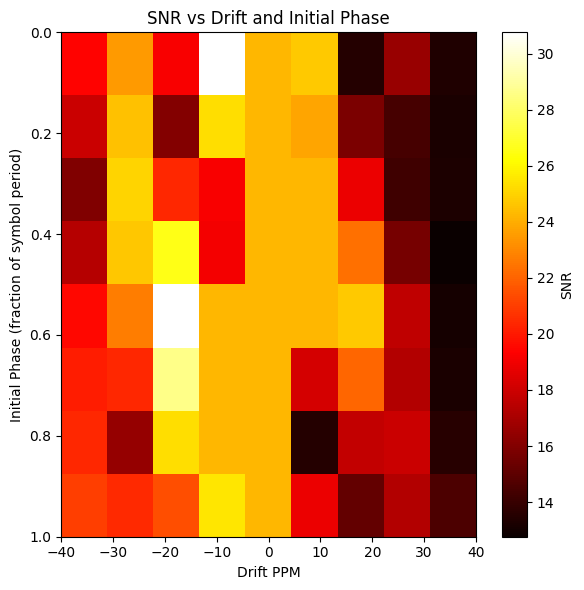

30.760384358503206 12.765007277020297 20.338116962749943


In [79]:
np.random.seed(42)
noise = np.random.normal(0, 10, size=2**16-1)
no_drift_corr_code = corr_code + noise
# ideal_corr = autocorr_same_length(no_drift_corr_code, np.roll(corr_code, seq_len//2), showFig=True)
# print(f"Ideal Peak: {np.max(ideal_corr)}")
# print(f"Ideal SNR: {np.max(ideal_corr) / np.mean(ideal_corr[1:])}")
# plt.plot(ideal_corr, '.-')
# plt.xlim(np.argmax(ideal_corr)-20, np.argmax(ideal_corr)+20)
# plt.show()

# positive_drift_corr_code = template_positive_drift[1::2] + noise
# ideal_corr = autocorr_same_length(positive_drift_corr_code, np.roll(template_positive_drift[1::2], seq_len//2), showFig=True)
# print(f"Ideal Peak: {np.max(ideal_corr)}")
# print(f"Ideal SNR: {np.max(ideal_corr) / np.mean(ideal_corr[1:])}")
# plt.plot(ideal_corr, '.-')
# plt.xlim(np.argmax(ideal_corr)-20, np.argmax(ideal_corr)+20)
# plt.show()



negative_drift_corr_code = generate_resampled_template_with_phase(
    base_pn_sequence,
    drift_ppm=-20, # -40 PPM drift
    samples_per_symbol=SAMPLES_PER_SYMBOL,
    num_output_samples=num_samples_to_generate,
    initial_phase=0.35,
    integration_duration=INTERATION_DURATION
)[1::2] + noise   # what is being sampled by the receiver

result_matrix = np.zeros((8, 9)) # 8 initial phases, 9 drift values
for initial_phase in np.arange(0, 1.0, 1/8):
    for drift_ppm in np.arange(-40, 41, 10):
        print(f"Testing with drift_ppm={drift_ppm}, initial_phase={initial_phase}")
        template_negative_drift = generate_resampled_template_with_phase(
            base_pn_sequence,
            drift_ppm=drift_ppm,
            samples_per_symbol=SAMPLES_PER_SYMBOL,
            num_output_samples=num_samples_to_generate,
            initial_phase=initial_phase, # try different initial phases,
            # integration_duration=INTERATION_DURATION
        )
        ideal_corr = autocorr_same_length(negative_drift_corr_code, template_negative_drift[1::2], showFig=False)
        print(f"Ideal Peak: {np.max(ideal_corr)}")
        print(f"Ideal SNR: {np.max(ideal_corr) / np.mean(ideal_corr[1:])}")
        result_matrix[int(initial_phase*8), int((drift_ppm+40)/10)] = np.max(ideal_corr) / np.mean(ideal_corr[1:])

plt.figure(figsize=(6, 6))
plt.imshow(result_matrix, cmap='hot', interpolation='nearest', extent=[-40, 40, 1, 0], aspect='auto')
plt.colorbar(label='SNR')
plt.xlabel('Drift PPM')
plt.ylabel('Initial Phase (fraction of symbol period)')
plt.title('SNR vs Drift and Initial Phase')
plt.tight_layout()
plt.show()

print(np.max(result_matrix), np.min(result_matrix), np.mean(result_matrix))

1 0 32768


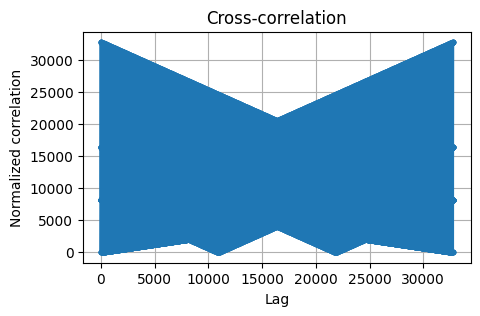

Ideal Peak: (32769+1.6559936215426395e-12j)
Ideal SNR: (32769.00000000036+1.5795460022617466e-12j)


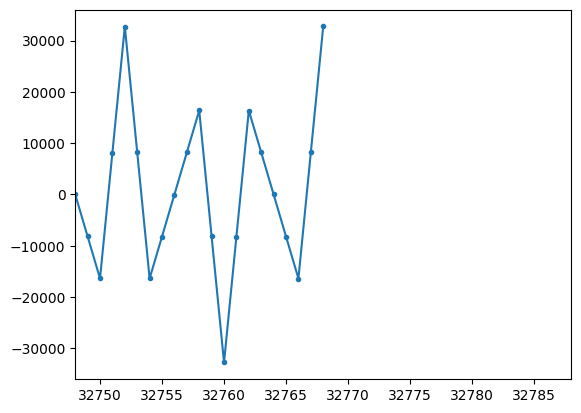

In [ ]:
corr_code = read_packed_kasami_h('./hadamard_code/hadamard_packed_order_32768_9.h')
print(max(corr_code), min(corr_code), len(corr_code))
corr_code = 2 * corr_code - 1  # Convert to bipolar (-1, 1) format
seq_len = len(corr_code)

shifted_corr_code = corr_code + np.random.normal(0, 0, size=seq_len)

# corr_code_repeated = np.repeat(corr_code, 2)
# assert (corr_code_repeated[1::2] == corr_code).all(), "Error in repeating the code!"

# random_indices = np.random.choice(len(corr_code_repeated), 2, replace=False)
# print(f"Randomly picked indices: {random_indices}")
# sampled = np.delete(corr_code_repeated, random_indices)
# # assert len(sampled) == len(corr_code), "Error in deleting one sample!"

ideal_corr = autocorr_same_length(shifted_corr_code, np.roll(corr_code, 0), showFig=True)
print(f"Ideal Peak: {np.max(ideal_corr)}")
print(f"Ideal SNR: {np.max(ideal_corr) / np.mean(ideal_corr[1:])}")
plt.plot(ideal_corr, '.-')
plt.xlim(np.argmax(ideal_corr)-20, np.argmax(ideal_corr)+20)
plt.show()

In [ ]:
print(1/67.109/10**6*10**9)

11920904.796674069


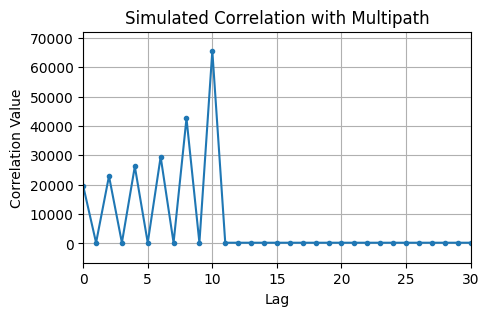

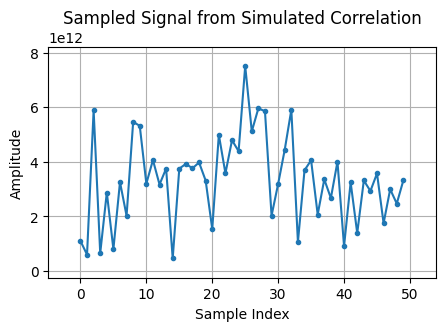

Randomly picked indices: [119133]
True


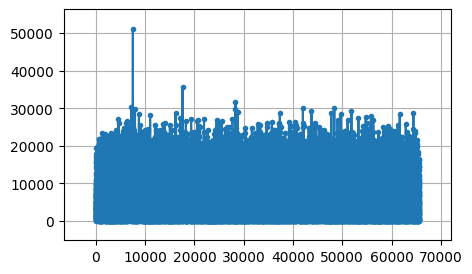

SNR: 8.33


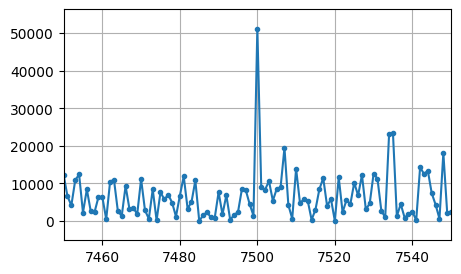

In [45]:
np.random.seed(42)
corr_code = read_packed_kasami_h('./kasami_code/kasami_packed_16bit_120.h')
corr_code = 2 * corr_code - 1  # Convert to bipolar (-1, 1) format
seq_len = len(corr_code)

pn_zero_inserted = [0]*(2*seq_len-1)
pn_zero_inserted[::2] = corr_code
# pn_zero_inserted[1::2] = pn[:-1]
# pn_zero_inserted = pn.copy()

pn_repeat = np.repeat(corr_code, 2)

static_vector = np.zeros(2*(2**16-1), dtype=complex)

pn_noisy = np.tile(pn_zero_inserted, 2)[0:len(static_vector)]
pn_noisy = np.roll(pn_noisy, 15000)

sampled = static_vector + pn_noisy * (1+0.5j) + (np.random.normal(0, 30, len(static_vector)) + 1j * np.random.normal(0, 30, len(static_vector)))

# randomly pick 10 index from the sampled signal
random_indices = np.random.choice(len(sampled), 1, replace=False)
print(f"Randomly picked indices: {random_indices}")
sampled = np.delete(sampled, random_indices)

sampled = sampled.reshape(-1, 1)
sampled_interpolated = insert_interpolated_frames(sampled, random_indices)
sampled_interpolated = sampled_interpolated[:, 0]

# corr_real = autocorr_same_length(pn, np.real(sampled), showFig=True)
# print(f"SNR: {np.max(corr_real) / np.mean(corr_real[1:])}")

# print(len(sampled_interpolated))
# print(len(pn_zero_inserted), len(sampled_interpolated))
# corr_real = autocorr_same_length(np.real(sampled_interpolated), pn_zero_inserted, showFig=True)
# print(f"SNR: {np.max(corr_real) / np.mean(corr_real[:]):.2f}")

# misaligned_sampled = np.append(np.delete(sampled_interpolated, [15000]), 0)
# corr_real = autocorr_same_length(np.real(misaligned_sampled), np.append(np.delete(pn_zero_inserted, [30000]), 0), showFig=True)
# print(f"SNR: {np.max(corr_real) / np.mean(corr_real[:]):.2f}")

print(len(sampled_interpolated[0::2]) == len(corr_code))
corr_real = autocorr_same_length(np.real(sampled_interpolated[0::2]), corr_code, showFig=True)
plt.figure(figsize=(5, 3))
plt.plot((corr_real), '.-')
plt.xlim(np.argmax(corr_real)-50, np.argmax(corr_real)+50)
plt.margins(0.1, 0.1)
plt.grid(True)
print(f"SNR: {np.max(corr_real) / np.mean(corr_real[:]):.2f}")


In [ ]:
np.random.seed(1)  # Set random seed for reproducibility
pn = get_PN(bits=8)  # Generate a maximum length sequence (MLS) of length 2^18 - 1
repeat_times = 1
noise_level = 10
pn_length = len(pn)  # Length of PN sequence
symbol_rate = 64  # Hz → symbol_duration = 1/1000 s
symbol_duration = 1 / symbol_rate
t_total = pn_length * symbol_duration * repeat_times

# Time resolution for waveform
base_fs = 128000  # High-res simulation (128kHz)
t = np.arange(0, t_total, 1 / base_fs)

mod_freq = 500
# mod_wave = np.sign(np.sin(2 * np.pi * mod_freq * t))
# generate a FMCW modulated signal (during t, mod frequency increases from 0 to 256Hz)
mod_freq_fmcw = np.linspace(0, mod_freq, len(t))
mod_wave = np.sign(np.sin(2 * np.pi * mod_freq_fmcw * t))

# Generate PN waveform
pn_waveform = np.repeat(np.tile(pn, repeat_times), len(t) // pn_length + 1)[:len(t)]
pn_waveform = pn_waveform * mod_wave

# --- Sampling with clock drift ---
epsilon = 0.005  # 5% clock drift → sampling interval = 1ms * (1 + epsilon)
ideal_sample_interval = 0.001  # 1ms
actual_sample_interval = ideal_sample_interval * (1 + epsilon)
init_phase = 2 / 8 * actual_sample_interval  # start sampling at 3/8 of the interval

# Create drifting sample times
sampling_times = np.arange(init_phase, t_total, actual_sample_interval)
sampled_signal = np.interp(sampling_times, t, pn_waveform) + np.random.normal(0, noise_level, len(sampling_times))

pn_sequence_sampled = np.interp(sampling_times, t, pn_waveform)
mod_sampled = np.interp(sampling_times, t, mod_wave)
corr_ = autocorr(pn_sequence_sampled, np.roll(sampled_signal, 1000))

fft_vals = np.fft.fft(mod_sampled * np.roll(sampled_signal, 1000))
plt.plot(np.abs(fft_vals), '.-')
plt.show()
plt.close()

corr_noise_level = np.mean(np.abs(corr_))
snr = 10 * np.log10(max(corr_) / corr_noise_level)
print(f"SNR: {snr:.2f} dB")

In [ ]:
# max correlation from different taps
max_corr_enable = [43.55, 44.36, 45.31, 46.22, 47.09, 47.93, 48.73, 49.48, 50.2, 50.87, 51.49, 52.07, 52.6, 53.09, 53.52, 53.91, 54.3, 55.1, 55.84, 56.54, 57.18, 57.77, 58.31, 58.8, 59.23, 59.6, 59.92, 60.19, 60.39, 60.54, 60.64, 60.68, 60.66, 60.59, 60.45, 60.27, 60.03, 59.73, 59.39, 58.98, 58.53, 58.03, 57.47, 56.87, 56.22, 55.53, 55.06, 55.57, 56.03, 56.46, 56.86, 57.21, 57.52, 57.8, 58.04, 58.24, 58.4, 58.53, 58.61, 58.66, 58.68, 58.66, 58.6, 58.51, 58.38, 58.23, 58.04, 57.82, 57.57, 57.29, 56.98, 56.65, 56.91, 57.75, 58.6, 59.45, 60.29, 61.14, 61.99, 62.83, 63.68, 64.52, 65.36, 66.2, 67.03, 67.86, 68.68, 69.49, 70.3, 71.11, 71.9, 72.69, 73.47, 74.24, 74.99, 75.74, 76.48, 77.2, 77.91, 78.61, 79.3, 79.97, 80.63, 81.27, 81.9, 82.51, 83.1, 83.68, 84.24, 84.79, 85.31, 85.82, 86.31, 86.78, 87.23, 87.67, 88.08, 88.48, 88.86, 89.21, 89.55, 89.87, 90.17, 90.45, 90.71, 90.95, 91.17, 91.38, 91.56, 91.73, 91.88, 92.01, 92.13, 92.22, 92.31, 92.37, 92.42, 92.45, 92.47, 92.48, 92.47, 92.45, 92.41, 92.37, 92.31, 92.8, 93.39, 93.94, 94.47, 94.96, 95.42, 95.85, 96.25, 96.62, 96.96, 97.26, 97.53, 97.78, 97.99, 98.17, 98.31, 98.43, 98.52, 98.58, 98.61, 98.62, 99.31, 100.49, 101.64, 102.76, 103.85, 104.9, 105.92, 106.9, 107.84, 108.74, 109.61, 110.43, 111.21, 111.94, 112.63, 113.28, 113.88, 114.43, 114.94, 115.39, 115.8, 116.16, 116.47, 116.73, 116.94, 117.1, 117.21, 117.27, 117.28, 117.24, 117.14, 117.0, 116.81, 116.56, 116.27, 115.93, 115.54, 115.11, 114.99, 115.74, 116.45, 117.11, 117.73, 118.29, 118.8, 119.26, 119.66, 120.0, 120.29, 120.52, 120.69, 120.79, 120.83, 120.8, 120.71, 120.56, 120.33, 120.04, 119.68, 119.25, 118.75, 118.17, 117.53, 116.82, 116.04, 115.18, 114.26, 113.26, 112.2, 111.07, 109.86, 108.59, 107.26, 105.85, 104.39, 102.85, 101.26, 99.61, 97.89, 96.12, 94.29, 93.44, 93.24, 92.97, 92.64, 92.23, 91.92, 91.9, 91.8, 91.64, 91.41, 91.1, 90.73, 90.28, 89.77, 89.18, 88.53, 87.81, 87.02, 86.16, 85.24, 84.26, 83.61, 83.72, 83.76, 83.73, 83.62, 83.45, 83.2, 82.88, 82.49, 82.01, 81.47, 81.53, 81.55, 81.51, 81.39, 81.22, 80.97, 80.65, 80.27, 79.82, 79.31, 78.72, 78.08, 77.36, 76.58, 75.74, 74.84, 75.35, 76.15, 76.89, 77.57, 78.19, 78.75, 79.25, 79.68, 80.05, 80.36, 80.6, 80.77, 80.88, 80.92, 80.89, 81.69, 83.58, 85.41, 87.16, 88.84, 90.43, 91.95, 93.39, 94.74, 96.0, 97.16, 98.24, 99.22, 100.1, 100.89, 101.57, 102.45, 103.62, 104.67, 105.61, 106.44, 107.18, 108.68, 110.04, 111.27, 112.36, 113.32, 114.13, 114.8, 115.33, 115.72, 115.96, 116.06, 116.02, 115.83, 115.7, 116.5, 117.18, 117.74, 118.17, 118.47, 118.65, 118.7, 118.62, 118.41, 118.07, 117.61, 117.02, 116.3, 115.46, 114.5, 113.41, 112.2, 110.87, 109.42, 107.86, 106.18, 104.4, 103.09, 102.09, 100.98, 99.77, 98.44, 97.0, 95.47, 93.83, 92.09, 90.99, 90.16, 89.23, 88.2, 87.07, 85.83, 84.51, 83.09, 81.58, 79.98, 78.29, 76.86, 75.72, 74.49, 73.19, 71.8, 70.33, 68.79, 67.68, 67.32, 66.86, 66.32, 65.68, 64.96, 64.15, 63.26, 62.29, 61.24, 60.11, 58.91, 57.93, 57.35, 57.04, 56.77, 56.41, 56.21, 55.94, 55.59, 55.15, 54.62, 54.08, 53.7, 53.21, 52.63, 51.95, 51.17, 50.3, 49.34, 48.3, 47.18, 47.26, 47.45, 47.53, 47.51, 47.38, 47.15, 46.83, 46.4, 45.88, 45.27, 44.56, 43.77, 42.89, 41.93, 40.88, 39.76, 38.57, 37.3, 35.97, 34.58, 33.42, 32.63, 32.42, 32.59, 32.68, 32.7, 32.65, 32.53, 32.34, 32.14, 32.41, 32.62, 32.76, 32.85, 32.87, 32.84, 33.36, 34.24, 35.04, 35.77, 36.43, 37.01, 37.51, 37.94, 38.3, 38.58, 38.79, 38.92, 38.98, 38.97, 38.89, 38.74, 38.52, 38.24, 37.89, 37.61, 38.27, 38.92, 39.48, 39.97, 40.38, 40.72, 40.97, 41.15, 41.25, 41.27, 41.34, 41.52, 41.95, 42.36, 42.71, 42.98, 43.18, 43.3, 43.35, 43.33, 43.23, 43.07, 42.83, 42.52, 42.14, 41.69, 41.18, 40.6, 39.95, 39.24, 38.47, 37.64, 36.75, 35.81, 34.81, 33.77, 32.67, 32.2, 31.87, 31.47, 31.01, 30.48, 29.9, 29.25, 28.54, 27.78, 26.97, 26.1, 25.42, 25.18, 24.91, 24.59, 24.23, 23.82, 23.37, 22.89, 22.37, 21.8, 21.66, 21.71, 21.74, 21.96, 22.57, 23.14, 23.66, 24.14, 24.57, 24.95, 25.29, 25.61, 26.14, 26.61, 27.02, 27.37, 27.66, 27.88, 28.04, 28.18, 28.48, 28.73, 28.93, 29.08, 29.18, 29.23, 29.24, 29.3, 29.7, 30.04, 30.32, 30.56, 30.73, 30.86, 30.93, 30.94, 30.9, 30.81, 30.74, 30.95, 31.11, 31.21, 31.25, 31.24, 31.17, 31.05, 30.93, 31.08, 31.17, 31.2, 31.18, 31.11, 30.98, 30.8, 30.57, 30.56, 30.49, 30.38, 30.22]
max_corr_disable = [45.53, 46.36, 47.13, 47.87, 48.55, 49.2, 49.79, 50.34, 50.85, 51.31, 51.72, 52.08, 52.4, 52.67, 52.9, 53.08, 53.21, 53.3, 53.69, 54.07, 54.41, 54.71, 54.97, 55.2, 55.39, 55.54, 55.88, 56.37, 56.81, 57.2, 57.55, 57.85, 58.11, 58.32, 58.48, 58.59, 58.65, 58.67, 58.64, 58.56, 58.43, 58.26, 58.04, 57.77, 57.45, 57.1, 56.69, 56.55, 56.52, 56.45, 56.34, 56.19, 56.0, 55.78, 55.51, 55.21, 54.88, 54.51, 54.11, 53.68, 53.22, 52.73, 52.79, 52.91, 53.0, 53.08, 53.86, 54.62, 55.38, 56.13, 56.87, 57.6, 58.32, 59.02, 59.72, 60.4, 61.08, 61.74, 62.39, 63.32, 64.25, 65.17, 66.08, 66.98, 67.86, 68.73, 69.58, 70.42, 71.24, 72.04, 72.82, 73.58, 74.33, 75.04, 75.74, 76.41, 77.06, 77.69, 78.28, 78.85, 79.93, 81.03, 82.12, 83.19, 84.24, 85.26, 86.27, 87.25, 88.21, 89.14, 90.04, 90.92, 91.76, 92.58, 93.36, 94.11, 94.82, 95.51, 96.15, 96.76, 97.33, 97.87, 98.37, 98.82, 99.24, 99.62, 99.96, 100.26, 100.52, 100.73, 100.91, 101.05, 101.14, 101.19, 101.21, 101.18, 101.11, 101.0, 100.86, 100.67, 100.45, 100.19, 99.89, 99.56, 99.19, 98.78, 98.35, 97.88, 97.38, 96.84, 96.28, 95.69, 95.08, 94.43, 94.1, 94.15, 94.17, 94.16, 94.13, 94.08, 94.0, 93.9, 94.88, 96.06, 97.2, 98.29, 99.34, 100.34, 101.28, 102.18, 103.02, 103.81, 104.54, 105.21, 105.83, 106.38, 106.87, 107.3, 107.66, 107.96, 108.2, 108.37, 108.47, 108.51, 108.49, 108.39, 108.23, 108.0, 107.71, 107.35, 106.93, 106.44, 105.89, 105.27, 104.59, 104.08, 104.49, 104.87, 105.21, 105.52, 105.78, 106.01, 106.19, 106.33, 106.44, 106.49, 106.51, 106.48, 106.4, 106.28, 106.11, 105.9, 105.64, 105.33, 104.98, 104.57, 104.12, 103.68, 103.26, 102.75, 102.16, 101.49, 100.73, 99.88, 98.96, 97.95, 97.01, 96.04, 95.03, 94.13, 93.53, 92.89, 92.38, 92.39, 92.36, 92.34, 92.32, 92.25, 92.22, 93.15, 94.01, 94.81, 95.54, 96.22, 96.82, 97.36, 97.82, 98.22, 98.54, 98.79, 98.97, 99.07, 99.1, 99.04, 98.91, 98.71, 98.42, 98.06, 97.62, 97.1, 96.5, 95.83, 95.07, 94.25, 93.34, 92.37, 91.32, 90.19, 89.0, 87.73, 86.4, 85.0, 83.54, 82.01, 80.87, 80.01, 79.08, 78.09, 77.04, 75.93, 74.77, 73.54, 72.26, 72.35, 72.38, 72.34, 72.24, 72.06, 72.13, 72.45, 72.72, 72.93, 73.08, 73.17, 73.21, 73.19, 73.79, 75.08, 76.33, 77.53, 78.67, 79.76, 80.79, 81.76, 82.67, 83.52, 84.3, 85.01, 85.66, 86.23, 86.74, 87.17, 87.52, 87.81, 88.01, 88.14, 88.2, 88.17, 88.07, 87.88, 87.62, 87.51, 87.86, 88.13, 88.33, 89.12, 89.86, 90.5, 91.06, 91.52, 91.89, 92.17, 92.35, 92.43, 92.42, 92.32, 92.4, 92.66, 92.81, 92.96, 93.65, 94.25, 94.74, 95.14, 95.44, 95.65, 95.75, 95.75, 95.65, 95.45, 95.16, 94.76, 94.26, 93.66, 92.96, 92.42, 91.8, 91.83, 91.86, 91.82, 91.68, 91.47, 91.17, 90.78, 90.31, 89.76, 89.12, 88.4, 87.6, 86.72, 85.76, 84.72, 83.61, 82.58, 81.77, 80.88, 79.89, 78.82, 77.66, 76.41, 75.08, 73.67, 72.18, 70.62, 68.99, 68.03, 67.59, 67.06, 66.45, 65.75, 64.96, 64.09, 63.14, 62.11, 61.43, 60.84, 60.17, 59.43, 58.61, 57.71, 57.09, 56.52, 55.87, 55.14, 54.35, 53.48, 52.54, 51.87, 51.28, 50.61, 49.86, 49.05, 48.16, 47.2, 46.5, 45.93, 45.42, 44.89, 44.3, 43.74, 43.37, 42.94, 42.76, 42.77, 42.7, 42.54, 42.3, 41.99, 41.59, 41.12, 41.48, 41.75, 41.95, 42.07, 42.11, 42.07, 41.96, 41.77, 41.51, 41.18, 40.77, 40.3, 39.76, 39.16, 38.49, 37.76, 36.97, 36.13, 35.23, 34.27, 33.27, 32.39, 32.0, 31.54, 31.36, 31.94, 32.46, 32.93, 33.34, 33.7, 33.99, 34.23, 34.42, 34.89, 35.94, 36.92, 37.85, 38.71, 39.51, 40.25, 40.93, 41.54, 42.08, 42.56, 42.97, 43.32, 43.6, 43.82, 43.97, 44.06, 44.08, 44.03, 43.93, 43.76, 43.53, 43.24, 42.89, 42.48, 42.02, 41.5, 40.93, 40.62, 40.48, 40.29, 40.04, 39.74, 39.38, 39.45, 39.54, 39.57, 39.56, 39.61, 39.61, 39.54, 39.42, 39.23, 38.99, 38.69, 38.33, 37.92, 37.46, 36.94, 36.38, 35.76, 35.1, 34.89, 34.92, 34.91, 34.85, 34.75, 34.6, 34.4, 34.16, 33.87, 33.54, 33.17, 32.76, 32.3, 31.81, 31.28, 30.71, 30.11, 29.47, 28.99, 28.67, 28.31, 27.93, 27.52, 27.09, 26.63, 26.15, 25.65, 25.13, 24.59, 24.03, 23.46, 23.37, 23.47, 23.53, 23.57, 23.57, 23.54, 23.48, 23.39, 23.28, 23.13, 22.96, 22.76, 22.59, 22.45, 22.59, 22.75, 22.86, 22.94, 22.97, 23.01, 23.04, 23.04, 23.01, 22.96, 22.88, 22.77, 22.98, 23.42, 23.82, 24.19, 24.53, 24.83, 25.09, 25.31, 25.5, 25.65, 25.75, 25.83, 25.86, 25.85, 25.8, 25.71, 25.58, 25.41, 25.2, 24.95, 24.66, 24.33, 23.96, 23.56, 23.25, 23.25, 23.23, 23.16]

print(f"the max correlation of enable is {max(max_corr_enable)}, index at {max_corr_enable.index(max(max_corr_enable))}")
print(f"the max correlation of disable is {max(max_corr_disable)}, index at {max_corr_disable.index(max(max_corr_disable))}")

import scienceplots
plt.style.use(['science', 'no-latex'])
plt.figure(figsize=(5, 3))
taps = np.arange(0, 600)
plt.plot(taps, max_corr_enable, label='Enable')
plt.plot(taps, max_corr_disable, label='Disable')
plt.xlabel('CIR Tap Index')
plt.ylabel('Max Correlation')
plt.legend()
plt.savefig('max_corr_with_tap.png', dpi=300, bbox_inches='tight')
plt.show()